# **Finding Lane Lines on the Road** 
***
In this project, you will use the tools you learned about in the lesson to identify lane lines on the road.  You can develop your pipeline on a series of individual images, and later apply the result to a video stream (really just a series of images). Check out the video clip "raw-lines-example.mp4" (also contained in this repository) to see what the output should look like after using the helper functions below. 

Once you have a result that looks roughly like "raw-lines-example.mp4", you'll need to get creative and try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines.  You can see an example of the result you're going for in the video "P1_example.mp4".  Ultimately, you would like to draw just one line for the left side of the lane, and one for the right.

---
Let's have a look at our first image called 'test_images/solidWhiteRight.jpg'.  Run the 2 cells below (hit Shift-Enter or the "play" button above) to display the image.

**Note** If, at any point, you encounter frozen display windows or other confounding issues, you can always start again with a clean slate by going to the "Kernel" menu above and selecting "Restart & Clear Output".

---

**The tools you have are color selection, region of interest selection, grayscaling, Gaussian smoothing, Canny Edge Detection and Hough Tranform line detection.  You  are also free to explore and try other techniques that were not presented in the lesson.  Your goal is piece together a pipeline to detect the line segments in the image, then average/extrapolate them and draw them onto the image for display (as below).  Once you have a working pipeline, try it out on the video stream below.**

---

<figure>
 <img src="line-segments-example.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your output should look something like this (above) after detecting line segments using the helper functions below </p> 
 </figcaption>
</figure>
 <p></p> 
<figure>
 <img src="laneLines_thirdPass.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your goal is to connect/average/extrapolate line segments to get output like this</p> 
 </figcaption>
</figure>

In [1]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
%matplotlib inline

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


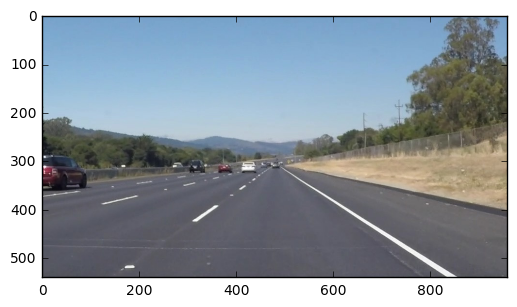

In [2]:
#reading in an image
image = mpimg.imread('test_images/solidWhiteRight.jpg')
#printing out some stats and plotting
print('This image is:', type(image), 'with dimesions:', image.shape)
plt.imshow(image)  #call as plt.imshow(gray, cmap='gray') to show a grayscaled image

**Some OpenCV functions (beyond those introduced in the lesson) that might be useful for this project are:**

`cv2.inRange()` for color selection  
`cv2.fillPoly()` for regions selection  
`cv2.line()` to draw lines on an image given endpoints  
`cv2.addWeighted()` to coadd / overlay two images
`cv2.cvtColor()` to grayscale or change color
`cv2.imwrite()` to output images to file  
`cv2.bitwise_and()` to apply a mask to an image

**Check out the OpenCV documentation to learn about these and discover even more awesome functionality!**

Below are some helper functions to help get you started. They should look familiar from the lesson!

In [3]:
import math

def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    you should call plt.imshow(gray, cmap='gray')"""
    return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image


def draw_lines(img, lines, color=[255, 0, 0], thickness=2):
    """
    NOTE: this is the function you might want to use as a starting point once you want to 
    average/extrapolate the line segments you detect to map out the full
    extent of the lane (going from the result shown in raw-lines-example.mp4
    to that shown in P1_example.mp4).  
    
    Think about things like separating line segments by their 
    slope ((y2-y1)/(x2-x1)) to decide which segments are part of the left
    line vs. the right line.  Then, you can average the position of each of 
    the lines and extrapolate to the top and bottom of the lane.
    
    This function draws `lines` with `color` and `thickness`.    
    Lines are drawn on the image inplace (mutates the image).
    If you want to make the lines semi-transparent, think about combining
    this function with the weighted_img() function below
    """
    for line in lines:
        for x1,y1,x2,y2 in line:
            cv2.line(img, (x1, y1), (x2, y2), color, thickness)

def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((*img.shape, 3), dtype=np.uint8)
    draw_lines(line_img, lines)
    return line_img

# Python 3 has support for cool math symbols.

def weighted_img(img, initial_img, α=0.8, β=1., λ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + λ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, λ)

### Image Processing Pipeline

The computer vision algorithms used in the pipeline have various tuning parameters. Collect the parameters we will as constants so that the pipeline can be tuned without altering the actual pipeline code.

In [4]:
# The size of the kernel to use for the Gaussian blur. The kernel size should be
# large enough to smooth out any noise in the image without being so large that
# important details are lost.
BLUR_KERNEL_SIZE = 5

# The image gradient thresholds used for the Canny edge detection algorithm.
# The Canny algorithm will accept any point with a gradient higher than the high
# threshold and reject any point with a gradient below the low threshold. For any
# points with gradients between the two thresholds, they will be accepted only if
# they are adjacent to a point that exceeds the high threshold.
CANNY_LOW_THRESHOLD = 50
CANNY_HIGH_THRESHOLD = 150

# The parameters used for the Hough line transform.
HOUGH_RHO = 1
HOUGH_THETA = np.pi/180
HOUGH_THRESHOLD = 10
HOUGH_MIN_LENGTH = 40
HOUGH_MAX_GAP = 20

# The region of interest restricts the area of the image in which we will look
# for lane markers.
REGION_OF_INTEREST = [(100, 539), (460, 320), (510, 320), (940, 539)]

Create an alternative draw_lines implementation that provides some additional postprocessing to the detected line segments.

In [5]:
def draw_lines(img, lines, color=[255, 0, 0], thickness=15):
    right_lines = []
    left_lines = []
    for line in lines:
        for x1,y1,x2,y2 in line:
            if x1 == x2:
                continue
                
            # Divide the line segments into left and right lane markers based
            # on the slope of the line, but filter out lines unlikely to be
            # lane edges.
            slope = float(y2 - y1) / float(x2 - x1)
            if slope > 0.25:
                right_lines.append([x1, y1, x2, y2])
            if slope < -0.25:
                left_lines.append([x1, y1, x2, y2])
    
    if len(left_lines) > 0:
        # Calculate bounding box of the left line segments.
        left_min_x = min(np.min(left_lines, axis=0)[0], np.min(left_lines, axis=0)[2])
        left_max_x = max(np.max(left_lines, axis=0)[0], np.max(left_lines, axis=0)[2])
        left_min_y = min(np.min(left_lines, axis=0)[1], np.min(left_lines, axis=0)[3])
        left_max_y = max(np.max(left_lines, axis=0)[1], np.max(left_lines, axis=0)[3])
        
        # If the bounding area doesn't reach the bottom of the screen, then
        # extend the area while preserving the slope of diagonal.
        if left_max_y < img.shape[0] - 1:
            slope = float(left_min_y - left_max_y) / float(left_max_x - left_min_x)
            left_max_y = img.shape[0] -1
            left_min_x = left_max_x + int((left_max_y - left_min_y) / slope)
            
        # Draw the left lane marker.
        cv2.line(img, (left_min_x, left_max_y), (left_max_x, left_min_y), color, thickness)
        
    if len(right_lines) > 0:
        # Calculate bounding box of the right line segments.
        right_min_x = min(np.min(right_lines, axis=0)[0], np.min(right_lines, axis=0)[2])
        right_max_x = max(np.max(right_lines, axis=0)[0], np.max(right_lines, axis=0)[2])
        right_min_y = min(np.min(right_lines, axis=0)[1], np.min(right_lines, axis=0)[3])
        right_max_y = max(np.max(right_lines, axis=0)[1], np.max(right_lines, axis=0)[3])
        
        # If the bounding area doesn't reach the bottom of the screen, then
        # extend the area while preserving the slope of diagonal.        
        if right_max_y < img.shape[0] - 1:
            slope = float(right_max_y - right_min_y) / float(right_max_x - right_min_x)
            right_max_y = img.shape[0] - 1
            right_max_x = right_min_x + int((right_max_y - right_min_y) / slope)
            
        # Draw the right lane marker.
        cv2.line(img, (right_min_x, right_min_y), (right_max_x, right_max_y), color, thickness)

Now construct the lane detection pipeline. This will take a single image and return a copy annotated with the detected lanes.

In [6]:
def image_pipeline(image):
    """
    This is the image processing pipeline. The passed in image will be transformed
    through a series of steps to detect lane lines. After the lane lines have been
    detected, the image will be annotated to highlight the detect lines and the
    annotated image will be returned.
    """
    
    # Convert the image to grayscale to minimize differences due to lane color or
    # lighting conditions.
    grayscale_image = grayscale(image)
        
    # Apply a Gaussian blur to the image.
    blurred_image = gaussian_blur(grayscale_image, BLUR_KERNEL_SIZE)
    
    # Apply the Canny edge detector to isolate edges in the image.
    canny_image =  canny(blurred_image, CANNY_LOW_THRESHOLD, CANNY_HIGH_THRESHOLD)
    
    # Clip the edges detected by the Canny detector to the region of interest.
    masked_image = region_of_interest(canny_image, np.array([REGION_OF_INTEREST], dtype=np.int32))
    
    # Apply the Hough transform to detect which of the edges detected by the Canny
    # transform correspond to a line.
    hough_image = hough_lines(masked_image, HOUGH_RHO, HOUGH_THETA, HOUGH_THRESHOLD, HOUGH_MIN_LENGTH, HOUGH_MAX_GAP)
    
    # Create a final image by drawing the detected lines on top of the original
    # image.
    processed_image = weighted_img(hough_image, image)
        
    return processed_image

Transform the sample image to verify that the pipeline is working as expected.

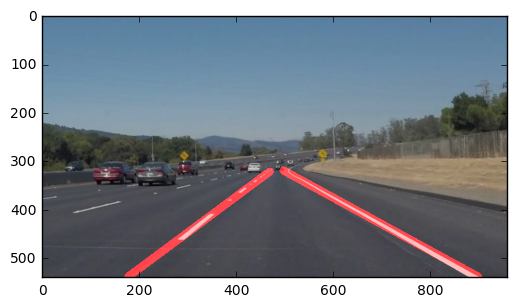

In [7]:
sample_image = mpimg.imread('test_images/solidWhiteCurve.jpg')

processed_image = image_pipeline(sample_image)                                  
ax = plt.imshow(processed_image)

## Test on Images

Now you should build your pipeline to work on the images in the directory "test_images"  
**You should make sure your pipeline works well on these images before you try the videos.**

In [8]:
import os
os.listdir("test_images/")

['processed_solidWhiteCurve.jpg',
 'processed_solidWhiteRight.jpg',
 'processed_solidYellowCurve.jpg',
 'processed_solidYellowCurve2.jpg',
 'processed_solidYellowLeft.jpg',
 'processed_whiteCarLaneSwitch.jpg',
 'solidWhiteCurve.jpg',
 'solidWhiteRight.jpg',
 'solidYellowCurve.jpg',
 'solidYellowCurve2.jpg',
 'solidYellowLeft.jpg',
 'whiteCarLaneSwitch.jpg']

run your solution on all test_images and make copies into the test_images directory).

In [9]:
for file in os.listdir('test_images/'):
    # Skip the processed images.
    if file.startswith("processed_"):
        continue

    # Read the image, process it, and then save the annotated image.
    image = mpimg.imread('test_images/' + file)
    processed_image = image_pipeline(image)
    mpimg.imsave('test_images/processed_' + file, processed_image)

## Test on Videos

You know what's cooler than drawing lanes over images? Drawing lanes over video!

We can test our solution on two provided videos:

`solidWhiteRight.mp4`

`solidYellowLeft.mp4`

In [10]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [11]:
def process_image(image):
    # NOTE: The output you return should be a color image (3 channel) for processing video below
    # TODO: put your pipeline here,
    # you should return the final output (image with lines are drawn on lanes)
    return image_pipeline(image)

Let's try the one with the solid white lane on the right first ...

In [12]:
white_output = 'white.mp4'
clip1 = VideoFileClip("solidWhiteRight.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video white.mp4
[MoviePy] Writing video white.mp4


100%|█████████▉| 221/222 [00:02<00:00, 91.91it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: white.mp4 

CPU times: user 2.04 s, sys: 509 ms, total: 2.55 s
Wall time: 2.81 s


Play the video inline, or if you prefer find the video in your filesystem (should be in the same directory) and play it in your video player of choice.

In [13]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

**At this point, if you were successful you probably have the Hough line segments drawn onto the road, but what about identifying the full extent of the lane and marking it clearly as in the example video (P1_example.mp4)?  Think about defining a line to run the full length of the visible lane based on the line segments you identified with the Hough Transform.  Modify your draw_lines function accordingly and try re-running your pipeline.**

Now for the one with the solid yellow lane on the left. This one's more tricky!

In [14]:
yellow_output = 'yellow.mp4'
clip2 = VideoFileClip('solidYellowLeft.mp4')
yellow_clip = clip2.fl_image(process_image)
%time yellow_clip.write_videofile(yellow_output, audio=False)

[MoviePy] >>>> Building video yellow.mp4
[MoviePy] Writing video yellow.mp4


100%|█████████▉| 681/682 [00:09<00:00, 75.18it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: yellow.mp4 

CPU times: user 7.65 s, sys: 1.85 s, total: 9.5 s
Wall time: 9.56 s


In [15]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(yellow_output))

## Reflections

Congratulations on finding the lane lines!  As the final step in this project, we would like you to share your thoughts on your lane finding pipeline... specifically, how could you imagine making your algorithm better / more robust?  Where will your current algorithm be likely to fail?

Please add your thoughts below,  and if you're up for making your pipeline more robust, be sure to scroll down and check out the optional challenge video below!


### Observations

This simple lane finding pipeline performs surprisingly well with the two sample videos. However, there are a few apparent limitation even here:

* A very aggressive region of interest was applied. In particular, the top of the region was selected to cut off some of the visible lane markings. This helps exclude some noise from cars or other objects converging at the horizon but also throws away information about upcoming changes to the lane.
* Only a simple filtering of line segments is performed while sorting them into left and right line segments based on their slope. In particular, we don't consider whether "left" line segments actually appear to the left and "right" line segments appear to the right. A stray edge detected in the other half of the region of interest would break this approach.
* No check is made to ensure that the detected lines have consistent slopes or are reasonably placed. Unexpected objects like other cars, trees, or even shadows could be misinterpreted as lane lines.
* The lane marking is drawn from the outer edge of the lane at the bottom to the inner edge of the lane at the time, resulting in a skewed lane marking. Ideally the marking would be drawn through the center of the lane lines.
* The lane marking is recomputed each frame, leading to jumps and bounces in the display. A better approach would be to smooth out differences between frames in the movie.

The pipeline can also be adversely impacted by changing road conditions. The two videos used in the test were made under relatively ideal conditions. The lane is wide open without obstructions or other cars which would result in unexpected edges being detected. The lane is not curving, so a single line drawn is sufficient to capture the lane. There is enough contrast for the edge detection algorithm to pick out lane lines without washing out the required color gradient needed to detect an edge.

## Submission

If you're satisfied with your video outputs it's time to submit!


## Optional Challenge

Try your lane finding pipeline on the video below.  Does it still work?  Can you figure out a way to make it more robust?  If you're up for the challenge, modify your pipeline so it works with this video and submit it along with the rest of your project!

In [16]:
# The challenge video is filmed at a different resolution, so adjust the region
# of interest for the new recording.
REGION_OF_INTEREST = [(133, 719), (660, 430), (680, 430), (1253, 719)]

In [17]:
challenge_output = 'extra.mp4'
clip2 = VideoFileClip('challenge.mp4')
challenge_clip = clip2.fl_image(process_image)
%time challenge_clip.write_videofile(challenge_output, audio=False)

[MoviePy] >>>> Building video extra.mp4
[MoviePy] Writing video extra.mp4


100%|██████████| 251/251 [00:08<00:00, 30.58it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: extra.mp4 

CPU times: user 5.56 s, sys: 1.9 s, total: 7.46 s
Wall time: 9.16 s


In [18]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_output))